In [3]:
import torch
from diffusers import StableDiffusionPipeline
#from PIL import Image
import numpy as np
from torchvision import transforms

# ============================
# 1. 모델 불러오기 및 준비
# ============================
model_id = "sd-legacy/stable-diffusion-v1-5" 
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,  
    torch_dtype=torch.float16,
    safety_checker=None  # 테스트 -> 안전 체크 비활성화
)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [23]:
#print(dir(pipe.unet))
"""
conv_in: 입력 latent를 처리하는 첫 번째 convolution 레이어
down_blocks: 입력을 점진적으로 다운샘플링하며 특징을 추출하는 블록들
mid_block: 다운샘플링된 특징을 처리하는 중간 블록
up_blocks: 업샘플링하면서 원래 해상도로 복원하는 블록들
conv_norm_out: 업블록의 출력을 정규화하는 레이어
conv_out: 최종적으로 noise 예측 혹은 결과를 생성하는 마지막 convolution 레이어
"""

'\nconv_in: 입력 latent를 처리하는 첫 번째 convolution 레이어\ndown_blocks: 입력을 점진적으로 다운샘플링하며 특징을 추출하는 블록들\nmid_block: 다운샘플링된 특징을 처리하는 중간 블록\nup_blocks: 업샘플링하면서 원래 해상도로 복원하는 블록들\nconv_norm_out: 업블록의 출력을 정규화하는 레이어\nconv_out: 최종적으로 noise 예측 혹은 결과를 생성하는 마지막 convolution 레이어\n'

In [32]:
from PIL import Image as PILImage

# ================================
# ASH 방식 -  활성화 처리 함수 (논문 참고)
# ================================
def ash_process(activations, keep_ratio=0.1, amplify_factor=10.0):
    """
    activations: 입력 활성화 텐서 (예: shape = [B, C, H, W])
    keep_ratio: 전체 값 중 상위 몇 %를 남길지 (예: 0.1이면 상위 10%만 남김)
    amplify_factor: 남은 값에 곱할 증폭 인자 (보통 1/keep_ratio, 여기서는 10.0)
    
    상위 10%의 값만 남기고 나머지는 0으로 만든 후 증폭하여 반환
    """
    
    # 활성화 텐서를 float32로 변환
    activations_float = activations.float()
    # float32 텐서를 사용해서 quantile 계산
    threshold = torch.quantile(activations_float, 1 - keep_ratio)
    # 임계값 이상인 위치는 1, 미만인 위치는 0인 마스크 생성
    mask = (activations_float >= threshold).float()
    # 마스크와 원래 값에 증폭 인자를 곱함
    processed_float = mask * activations_float * amplify_factor
    # 원래 텐서의 dtype (예: float16)로 변환하여 반환할 수도 있음
    processed = processed_float.to(activations.dtype)
    return processed, threshold

# ------------------------------
# 2. 내부 활성화 값 추출을 위한 Hook 등록 (= Layer선택), 
#   논문에서는 마지막 쯤 layer를 선택하는 것이 효과가 좋다고 함. -> conv_out 선택

# ------------------------------

activation_store = {}

def hook_fn_ash(module, input, output):
    # # output은 tensor 또는 tuple 형태일 수 있음.
    # activation_store["conv_out"] = output.detach().float()  # CPU 또는 float32로 변환
    
    # output: hook이 걸린 레이어의 출력 활성화값
    processed_output, threshold = ash_process(output, keep_ratio=0.1, amplify_factor=10.0)
    # 후처리된 활성화와 임계값을 저장 (추후 분석용)
    activation_store["ash_layer"] = processed_output.detach().float()
    activation_store["ash_threshold"] = threshold.detach().float()
    # 반환한 값로 후속 연산에도 적용되므로, 반환값을 processed_output으로 함
    return processed_output

# sd-legacy 모델의 UNet 내부 첫 번째 convolution 레이어에 hook 등록
hook_handle = pipe.unet.conv_out.register_forward_hook(hook_fn_ash)

In [14]:
# ------------------------------
# 3. 이미지 전처리 함수
# ------------------------------
def load_and_preprocess_image(image_path, size=512):
    """
    이미지 파일을 로드-> (1, C, H, W) 텐서로 변환 후 [-1, 1] 범위로 정규화.
    """
    image = PILImage.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),  # [0,1] 범위
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1,1] 범위로 변환
    ])
    return transform(image).unsqueeze(0)


In [28]:
def run_experiment(image_path):
    # (1) 이미지 로드 및 전처리, GPU와 float16 타입으로 변환
    image_tensor = load_and_preprocess_image(image_path).to(pipe.device, dtype=torch.float16)
    
    # (2) VAE 인코딩을 통해 latent 추출
    with torch.no_grad():
        latent_dist = pipe.vae.encode(image_tensor).latent_dist
        latent = latent_dist.sample() * 0.18215  # Stable Diffusion 스케일 팩터 적용

    # (3) diffusion 과정에 사용할 timestep 및 dummy 텍스트 조건부 생성
    timestep = torch.tensor([500], device=pipe.device).long()
    encoder_hidden_states = torch.zeros((1, 77, 768), device=pipe.device, dtype=torch.float16)
    
    # (4) UNet forward pass 수행: 이때 hook 함수가 conv_out에 적용되어 ASH 처리됨
    with torch.no_grad():
        _ = pipe.unet(latent, timestep, encoder_hidden_states)
    
    # (5) hook에 저장된 후처리된 활성화값과 임계값 추출
    processed_activation = activation_store.get("ash_layer", None)
    threshold = activation_store.get("ash_threshold", None)
    if processed_activation is None:
        print("Hook에서 활성화 값을 저장하지 못했습니다.")
        return None

    # (6) 간단한 통계 예: 후처리된 활성화의 평균값을 OOD 지표로 활용
    stat = processed_activation.mean().item()
    print(f"이미지: {image_path}")
    print(f"ASH 임계값 (상위 10% 기준): {threshold.item():.4f}")
    print(f"ASH 후 활성화 평균: {stat:.4f}")
    return stat

In [36]:
# 6. 실험 실행 예시
# ================================
if __name__ == "__main__":
    # 실험에 사용할 이미지 경로 (예: 정상 이미지와 OOD 후보)
    image_paths = [
        "/home/jovyan/data/yejin/flower.png",
        "/home/jovyan/data/yejin/CT.jpg"  # CT 영상 등, 모델 학습 분포와 다른 도메인의 이미지
    ]
    scores = {}
    for path in image_paths:
        score = run_experiment(path)
        scores[path] = score
    print("\n실험 결과 (각 이미지의 ASH 후 평균 활성화):")
    for path, score in scores.items():
        print(f"{path}: {score:.4f}")

이미지: /home/jovyan/data/yejin/flower.png
ASH 임계값 (상위 10% 기준): 87.6250
ASH 후 활성화 평균: 119.4197
이미지: /home/jovyan/data/yejin/CT.jpg
ASH 임계값 (상위 10% 기준): 55.9062
ASH 후 활성화 평균: 93.0344

실험 결과 (각 이미지의 ASH 후 평균 활성화):
/home/jovyan/data/yejin/flower.png: 119.4197
/home/jovyan/data/yejin/CT.jpg: 93.0344


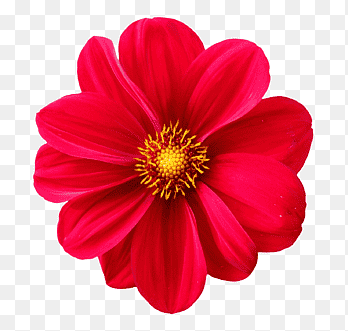

In [16]:
import os
from IPython.display import display

# 현재 디렉토리에 "flower.png"가 있는지 확인
if os.path.exists("flower.png"):
    # 이미지 파일을 표시
    display(Image(filename="flower.png"))
else:
    print("현재 디렉토리에 'flower.png' 파일이 존재하지 않습니다.")